In [0]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
sys.path.append('harbour-space-text-mining-course')

from tmcourse.utils import (
    enable_mathjax_in_cell,
    display_pca_scatterplot,
    display_pca_scatterplot_interactive
)
from tmcourse.demo import (
    demo_word2vec_batch,
    demo_gradient_descent,
)
from tmcourse.quiz import (
    quiz_skibidi,
    quiz_word2vec_context,
    quiz_word2vec_word_vector,
    quiz_word2vec_subsampling,
    quiz_word2vec_negative_sampling,
    quiz_most_similar,
    quiz_earl,
)
from tmcourse.ipyquiz import Quiz
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 399 (delta 64), reused 59 (delta 32), pack-reused 307
Receiving objects: 100% (399/399), 40.02 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (247/247), done.


# Sparsity problem

In [0]:
np.squeeze(np.asarray(vector_1.todense()))

array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
import pandas as pd
df = pd.read_csv("harbour-space-text-mining-course/datasets/quora_question_pairs/train.csv")
print(df.iloc[7])

# words 'good' and 'great' are similar, but have different TF-IDF representations
# let's see if it makes any difference
from sklearn.feature_extraction.text import TfidfVectorizer
df.iloc[7]["question1"]
vec = TfidfVectorizer()
vec.fit(list(df["question1"].fillna(".")) + list(df["question2"].fillna(".")))

question_1 =              "How can I be a good geologist?"
question_2 =              "What should I do to be a great geologist?"
question_2_reformulated = "What should I do to be a good geologist?"

def row_to_array(sparse_matrix_row):
    return np.squeeze(np.asarray(sparse_matrix_row.todense()))

vector_1 = row_to_array(vec.transform([question_1]))
vector_2 = row_to_array(vec.transform([question_2]))
vector_2_reformulated = row_to_array(vec.transform([question_2_reformulated]))
import numpy as np
from scipy.spatial.distance import cosine
# vector_2_reformulated is closer to vector_1 than vector_2
print("vector_1 * vector_2:", cosine(vector_1, vector_2))
print("vector_1 * vector_2_reformulated:", cosine(vector_1, vector_2_reformulated))

id                                                      7
qid1                                                   15
qid2                                                   16
question1                  How can I be a good geologist?
question2       What should I do to be a great geologist?
is_duplicate                                            1
Name: 7, dtype: object
vector_1 * vector_2: 0.2393080067483847
vector_1 * vector_2_reformulated: 0.10714690263538829


# Word meanings. Distributional hypothesis.

## Colab quiz 1
What is "skibidi"?

In [0]:
quiz_skibidi()()

Actually, neither the word "skibidi" nor the definitions 1-4 exist.
This quiz was generated using https://www.thisworddoesnotexist.com/

# word2vec: idea

## Colab demo: word2vec sliding window

In [0]:
demo_word2vec_batch("never gonna give you up never gonna let you down".split(), 3)

## Colab demo: gradient descent

In [0]:
demo_gradient_descent(lambda x: x**4 - x**3 - x**2 + 1, theta_0=-1, learning_rate=0.5)  # local minima
# demo_gradient_descent(lambda x: x**2, theta_0=-1, learning_rate=1.1)  # divergence

## Colab quiz 2
Choose the correct context

In [0]:
quiz_word2vec_context()()

# word2vec: algorithm

In [0]:
import numpy as np
from collections import Counter
from scipy.special import softmax
from scipy.special import expit as sigmoid  # "expit" is the inverse of "logit"
from scipy.spatial.distance import cosine as cosine_distance

class Word2Vec:
    """
    This is an instructive implementation of skip-gram word2vec algorithm with negative sampling loss.
    It is deliberately inefficient: it uses built-in Python data structures (dicts and lists)
    instead of matrix-vector operations.

    The recommended way to read the code is the following:
    1. First, read the implementation of the `train()` method:
        - Training loop: iterate few times (epochs) over the training data.
          Number of epochs is provided in the `n_epoch` parameter,
          and `self.learning_rate` is predefined step size of gradient descent.
        - In each iteration, a batch (central_word and context_words) is generated.
        - Too frequent words are discarded (subsampling).
        - The gradients are computed and gradient step is performed.
    2. Then look at the method `generate_batches()`.
       It creates pairs (central word, [list of context words])
       by moving sliding window of predefined size `self.window_size`.
    3. Then check the `generate_negative_samples()` method.
       Its implementation is short, but there are two important details:
       - Sampling is performed with replacement. It mimics i.i.d. assumption:
         negative samples must be independent.
       - The central word and the context word are discarded from the set 
         of negative samples.
    4. The most important part is how gradients are computed: the method `compute_gradients()`.
       All the gradients are derived in this lecture; this method just implements them in Python code.
    5. Then take a look at `build_vocabulary()`: it is mostly technical.
    6. `get_vector()` method is just a one-liner, but pay attention to the fact
       that we use only one of two matrices (the matrix of central vectors).
    7. `get_similar_words()` method implements inefficient (O(|V|)) search of
       words whose vectors are closest to the vector of the given word.
    8. `__init__()` method just stores all hyperparameters and initializes necessary data structures.
    """
    def __init__(
        self,
        window_size=2,
        vector_size=10,
        n_negative_samples=20,
        learning_rate=1e-5,
        seed=0
    ):
        self.window_size = window_size
        self.learning_rate = learning_rate

        self.vocab = Counter()

        # how many dimensions each vector has
        self.vector_size = vector_size
        # vectors are initialized in .build_vocabulary() after the vocabulary is known
        self.central_vectors = dict()  
        self.context_vectors = dict()

        # number of negative samples for each context word
        self.n_negative_samples = n_negative_samples

        # prepare vocabulary for negative sampling and sumsampling
        self.words_array = []
        self.negative_sampling_probabilities = []
        self.subsampling_probabilities = dict()

        np.random.seed(seed)

    def build_vocabulary(self, sequences):
        # count all the words
        for sequence in sequences:
            for word in sequence:
                self.vocab[word] += 1

        sum_counts_negative_sampling = sum(v**0.75 for v in self.vocab.values())
        sum_counts_subsampling = sum(self.vocab.values())
        for word, count in self.vocab.items():
            self.words_array.append(word)
            self.negative_sampling_probabilities.append(count**0.75 / sum_counts_negative_sampling)
            word_frequency = count / sum_counts_subsampling
            self.subsampling_probabilities[word] = (1 + np.sqrt(word_frequency / 0.001)) * 0.001 / word_frequency

        # initialize vectors with small values around 0
        for word in self.vocab:
            self.central_vectors[word] = np.random.randn(self.vector_size) * 0.1
            self.context_vectors[word] = np.random.randn(self.vector_size) * 0.1

    def generate_batches(self, sequence):
        # move sliding window over the sequence 
        # for each position of the window generate list of context words
        # return list of lists pairs (central word, [context words])
        batches = []
        for i_central, central_word in enumerate(sequence):
            # ignore the words outside of vocabulary (we don't have vectors for them)
            if central_word not in self.vocab:
                continue
            context_words = []
            # iterate from i_central - window_size, i_central + window_size
            for i_context in range(i_central - self.window_size, i_central + self.window_size + 1):
                # handle boundary cases
                if i_context < 0 or i_context >= len(sequence):
                    continue
                # exclude the central word itself
                if i_context == i_central:
                    continue
                context_word = sequence[i_context]
                # ignore the words outside of vocabulary
                if context_word not in self.vocab:
                    continue
                # update the batch that corresponds to the current central word
                context_words.append(context_word)
            # update batches with the collected batch
            batches.append((central_word, context_words))
        return batches

    def generate_negative_samples(self, central_word, context_word):
        negative_samples = np.random.choice(
            self.words_array,
            size=self.n_negative_samples,
            replace=True,  # sampling with replacement: mimics i.i.d assumption
            p=self.negative_sampling_probabilities
        )
        return [n for n in negative_samples if n != central_word and n != context_word]

    def compute_gradients(self, central_word, context_word, negative_samples):
        central_vector = self.central_vectors[central_word]

        # accumulate gradient of the central word
        central_word_gradient = np.zeros(self.vector_size)

        context_word_vector = self.context_vectors[context_word]
        context_words_gradient = -central_vector * (1 - sigmoid(np.dot(context_word_vector, central_vector)))

        central_word_gradient += -context_word_vector * (1 - sigmoid(np.dot(context_word_vector, central_vector)))

        # a word in negative sample can be sampled many times, so we accumulate gradients
        negative_samples_gradients = {n: np.zeros(self.vector_size) for n in negative_samples}
        for negative_sample in negative_samples:
            negative_sample_vector = self.context_vectors[negative_sample]
            negative_samples_gradients[negative_sample] += central_vector * (1 - sigmoid(-np.dot(negative_sample_vector, central_vector)))
            central_word_gradient += negative_sample_vector * (1 - sigmoid(-np.dot(negative_sample_vector, central_vector)))

        return central_word_gradient, context_words_gradient, negative_samples_gradients

    def train(self, sequences, n_epoch=5):
        T = 0
        for epoch in range(n_epoch):
            for sequence in sequences:
                # learning rate decays proportional to the number of iterations
                # similar to the original word2vec code
                alpha = self.learning_rate * max(0.0001, (1 - T / (n_epoch * len(sequences))))
                T += 1
                for batch in self.generate_batches(sequence):
                    central_word, context_words = batch

                    # subsample: randomly discard too frequent words
                    if np.random.random() > self.subsampling_probabilities[central_word]:
                        continue

                    for context_word in context_words:
                        # generate negative samples
                        # negative samples do not include the central word and the context word
                        negative_samples = self.generate_negative_samples(central_word, context_word)

                        # compute gradients
                        central_word_gradient, context_word_gradient, negative_samples_gradients = self.compute_gradients(
                            central_word, context_word, negative_samples
                        )
                        # perform one step of gradient descent: update all the parameters in direction opposite to gradient
                        self.central_vectors[central_word] -= alpha * central_word_gradient
                        self.context_vectors[context_word] -= alpha * context_word_gradient
                        for negative_sample in negative_samples:
                            self.context_vectors[negative_sample] -= alpha * negative_samples_gradients[negative_sample]

    def get_vector(self, word):
        return self.central_vectors[word]

    def get_similar_words(self, word, k=10):
        word_vector = self.get_vector(word)
        cosine_similarities = [1 - 0.5 * cosine_distance(word_vector, self.get_vector(w)) for w in self.words_array]
        return list(
            reversed([
                (self.words_array[i], cosine_similarities[i])
                for i in np.argsort(cosine_similarities)[-k-1:-1]  # exclude the word itself
            ])
        )


In [0]:
# toy example: "A" and "B" always occur near X
# all the other words (actually, characters) from the left and from the right are random
from string import ascii_lowercase
import random
from pprint import pprint

random.seed(0)
n_examples = 1000
# generate random left and right halves
left_contexts = [random.choices(ascii_lowercase, k=5) for _ in range(n_examples)]
right_contexts = [random.choices(ascii_lowercase, k=5) for _ in range(n_examples)]

# insert "XA" and "XB" to the middle
toy_dataset = [
    l + list("XA") + r for l, r in zip(left_contexts, right_contexts)
] + [
    l + list("XB") + r for l, r in zip(left_contexts, right_contexts)
]
random.shuffle(toy_dataset)

print("A few lines of the toy dataset:")
print("\n".join(["".join(t) for t in toy_dataset[:3]]))
window_size = 1
vector_size = 2
learning_rate = 0.1
n_epoch = 5
n_negative_samples = 5
word2vec = Word2Vec(
    seed=1,
    window_size=window_size,
    vector_size=vector_size,
    learning_rate=learning_rate,
    n_negative_samples=n_negative_samples
)
word2vec.build_vocabulary(toy_dataset)
word2vec.train(toy_dataset, n_epoch=n_epoch)
print("Words most similar to 'A'")
pprint(word2vec.get_similar_words("A"))

A few lines of the toy dataset:
vohgkXAyfvap
lgenmXAfojrf
lpkohXBwinqm
Words most similar to 'A'
[('B', 0.9999876210481136),
 ('z', 0.957950766495169),
 ('a', 0.9129377419737473),
 ('k', 0.9053724127989855),
 ('i', 0.9034941870030813),
 ('b', 0.8990275152337034),
 ('n', 0.8655117493755606),
 ('g', 0.8500906263010772),
 ('t', 0.8474761246122444),
 ('m', 0.842807328160446)]


## Colab quiz 3

How are word vectors computed?

In [0]:
quiz_word2vec_word_vector()()

## Colab quiz 4

Which words are subsampled?

In [0]:
quiz_word2vec_subsampling()()

## Colab quiz 5

Details of negative sampling

In [0]:
quiz_word2vec_negative_sampling()()

## Derivation of gradients

## Exercise 1
Derive the gradient

## Exercise 2

Derive the gradient

# word2vec in gensim

## How to train

In [0]:
print("Words most similar to 'A' (gensim implementation)")
from gensim.models import Word2Vec as Word2Vec

gensim_word2vec = Word2Vec(
    sg=1,  # skip-gram
    hs=0,  # negative sampling
    size=vector_size,
    window=window_size,
    alpha=learning_rate,
    negative=n_negative_samples
)
gensim_word2vec.build_vocab(toy_dataset)
gensim_word2vec.train(toy_dataset, total_examples=len(toy_dataset), epochs=n_epoch)
pprint(gensim_word2vec.wv.most_similar("A"))

Words most similar to 'A' (gensim implementation)
[('B', 0.998858630657196),
 ('r', 0.8648688793182373),
 ('v', 0.8459551930427551),
 ('d', 0.818452000617981),
 ('l', 0.8164636492729187),
 ('p', 0.8162599802017212),
 ('e', 0.7865331172943115),
 ('z', 0.7710384130477905),
 ('j', 0.7568649649620056),
 ('m', 0.7528473734855652)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# try real dataset
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(
    subset="all",
    shuffle=True,
    random_state=1,
    remove=('headers', 'footers', 'quotes')
)

from tqdm.notebook import tqdm
import spacy

# extract tokens (lemmas) with spaCy
# keep only nouns, adjectives, verbs and adverbs
nlp = spacy.load("en", disable=['parser', 'ner', 'tagger'])
def tokens(s):
    return [t.lemma_ for t in nlp(s)]

texts = [tokens(text) for text in tqdm(dataset.data, desc="tokenize")]

In [0]:
# initialize, build vocabulary and train at once
gensim_word2vec = Word2Vec(
    texts,
    sg=1,  # skip-gram
    hs=0,  # negative sampling
    size=32,
    window=5,  # context is a 5-word window around the target word
    min_count=5  # ignore words that occur less than 5 times
).wv  # "wv" stands for "word vectors"

In [0]:
gensim_word2vec.most_similar("space")

[('satellite', 0.8594409227371216),
 ('exploration', 0.8373710513114929),
 ('interstellar', 0.818328857421875),
 ('constraint', 0.8176926970481873),
 ('projection', 0.8134022355079651),
 ('invest', 0.8124356269836426),
 ('lunar', 0.8121957778930664),
 ('navigation', 0.810688853263855),
 ('transport', 0.810165524482727),
 ('colony', 0.8095486164093018)]

In [0]:
gensim_word2vec.most_similar("gif")

[('PCX', 0.9543694257736206),
 ('BMP', 0.954302191734314),
 ('Targa', 0.9317119121551514),
 ('JPG', 0.9163984060287476),
 ('PICT', 0.911790132522583),
 ('MPEG', 0.9062026143074036),
 ('TIFF', 0.9037772417068481),
 ('PPM', 0.9029632806777954),
 ('xpm', 0.9008678793907166),
 ('bitmaps', 0.899631142616272)]

In [0]:
gensim_word2vec.most_similar("hockey")

[('baseball', 0.9595075845718384),
 ('NHL', 0.8969776630401611),
 ('basketball', 0.8906586170196533),
 ('ESPN', 0.8813546299934387),
 ('playoff', 0.8692588806152344),
 ('football', 0.8609351515769958),
 ('team', 0.8584728240966797),
 ('league', 0.8549729585647583),
 ('talent', 0.8443048000335693),
 ('game', 0.837999165058136)]

## Pre-trained vectors

In [0]:
import gensim.downloader as api

# list all available models
from tabulate import tabulate
from IPython.display import display, HTML
all_gensim_models = api.info()["models"]
gensim_model_description = [(m, all_gensim_models[m]["description"]) for m in all_gensim_models]
display(HTML(tabulate(gensim_model_description, headers=("model name", "description"), tablefmt="html")))

model name,description
fasttext-wiki-news-subwords-300,"1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)."
conceptnet-numberbatch-17-06-300,"ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting."
word2vec-ruscorpora-300,Word2vec Continuous Skipgram vectors trained on full Russian National Corpus (about 250M words). The model contains 185K words.
word2vec-google-news-300,Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).
glove-wiki-gigaword-50,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-100,"Pre-trained vectors based on Wikipedia 2014 + Gigaword 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-200,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-300,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-twitter-25,"Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-twitter-50,"Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)"


In [0]:
# load relatively small (128MB) model
model = api.load("glove-wiki-gigaword-100")

In [0]:
model.most_similar("hockey")

[('basketball', 0.8041675090789795),
 ('football', 0.7833694219589233),
 ('nhl', 0.7604307532310486),
 ('soccer', 0.7440757751464844),
 ('baseball', 0.7312085628509521),
 ('league', 0.7092335224151611),
 ('skating', 0.670417070388794),
 ('lacrosse', 0.6691610813140869),
 ('team', 0.6619707345962524),
 ('games', 0.6571609973907471)]

## Colab quiz 6

What is the most similar to "twitter"?

In [0]:
quiz_most_similar()()

# Visualization of word vectors

## Principal Component Analysis (PCA)
![PCA of a multivariate Gaussian distribution centered at (1,3) with a standard deviation of 3 in roughly the (0.866, 0.5) direction and of 1 in the orthogonal direction.](https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg)

(-6.581974524964871,
 6.159690530073089,
 -10.478850453558627,
 10.517391036705472)

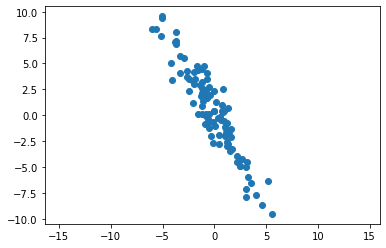

In [0]:
# project 2-dimensional ellipsoid onto a 1-dimensional line
# in other words: explain each point with a single number
def rotation_matrix(radians):
    c, s = np.cos(radians), np.sin(radians)
    return np.matrix([[c, s], [-s, c]])

def generate_cloud(size, var1, var2, radians):
    import numpy as np
    j = rotation_matrix(radians)
    return np.asarray(np.random.multivariate_normal([0., 0.], [[var1, 0], [0, var2]], size=size) @ j)

cloud = generate_cloud(100, 0.5, 20, 0.5)
import matplotlib.pyplot as plt

plt.scatter(cloud[:, 0], cloud[:, 1])
plt.axis("equal")

(-11.877191450976502,
 12.127730069548091,
 -1.8950148271686937,
 2.2126203675280673)

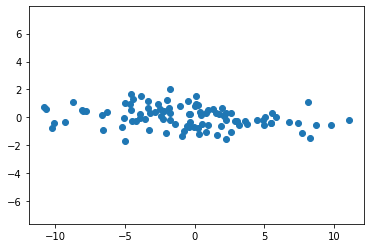

In [0]:
# find the rotation angle via slope
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(cloud[:, 0].reshape(-1, 1), cloud[:, 1])
# clf.coef_ is the slope = tan(rotation angles)
# rotate back
angle_to_rotate = -np.arctan(clf.coef_).item()
rotated_cloud = np.asarray(cloud @ rotation_matrix(angle_to_rotate))
plt.scatter(
    rotated_cloud[:, 0],  # the first principal component
    rotated_cloud[:, 1]
)
plt.axis("equal")

(-11.368042128047925,
 12.658875935944241,
 -2.1263203330082066,
 2.136132845397986)

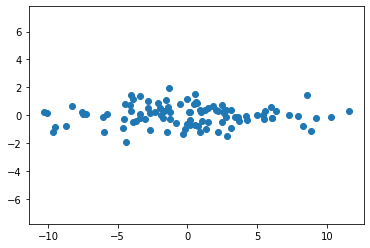

In [0]:
from sklearn.decomposition import PCA
trf = PCA()
result = trf.fit_transform(cloud)

plt.scatter(result[:, 0], result[:, 1])
plt.axis("equal")

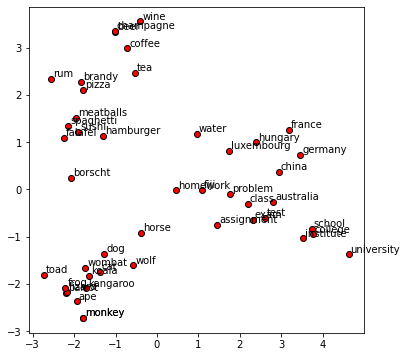

In [0]:
display_pca_scatterplot(
    model,
    ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
    'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
    'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
    'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
    'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
    'homework', 'assignment', 'problem', 'exam', 'test', 'class',
    'school', 'college', 'university', 'institute']
)

https://projector.tensorflow.org/

# Properties of word vectors

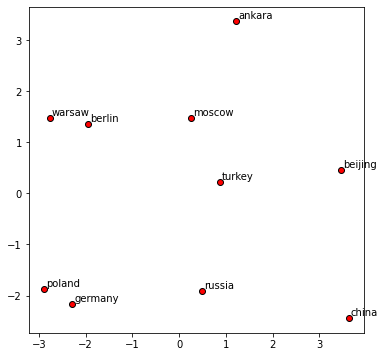

In [0]:
display_pca_scatterplot(
    model,
    [
        "china", "beijing",
        "russia", "moscow",
        "turkey", "ankara",
        "poland", "warsaw",
        "germany", "berlin",
    ]
)

For example, 
$$
\overrightarrow{\mathrm{Warsaw}} - \overrightarrow{\mathrm{Poland}} \approx  \overrightarrow{\mathrm{Moscow}} - \overrightarrow{\mathrm{Russia}}
$$
or, equivalently
$$
\overrightarrow{\mathrm{Warsaw}} - \overrightarrow{\mathrm{Poland}}  + \overrightarrow{\mathrm{Russia}} \approx \overrightarrow{\mathrm{Moscow}}
$$

Thus, word vectors represent some (but not all!) relations between words ("Warsaw is related to Poland the same way Moscow is related to Russia").

In [0]:
from scipy.spatial.distance import cosine
print("Distance between <warsaw> and <moscow>:", cosine(model["warsaw"], model["moscow"]))
print("Distance between <poland> and <russia>:", cosine(model["poland"], model["russia"]))
print("Distance between <warsaw> - <poland> + <russia> and <moscow>:", cosine(model["warsaw"] - model["poland"] + model["russia"], model["moscow"]))

Distance between <warsaw> and <moscow>: 0.3461671471595764
Distance between <poland> and <russia>: 0.3346114158630371
Distance between <warsaw> - <poland> + <russia> and <moscow>: 0.13101792335510254


In [0]:
# we can solve word analogy task with gensim
model.most_similar(positive=["poland", "moscow"], negative=["warsaw"])

[('russia', 0.8804728984832764),
 ('ukraine', 0.8040169477462769),
 ('greece', 0.7516032457351685),
 ('bulgaria', 0.7362306118011475),
 ('turkey', 0.7311098575592041),
 ('belarus', 0.7300174236297607),
 ('russian', 0.70297771692276),
 ('kazakhstan', 0.7012521624565125),
 ('armenia', 0.6977461576461792),
 ('iran', 0.6883851885795593)]

## Colab quiz 7

In [0]:
enable_mathjax_in_cell()
quiz_earl()()

# Recommended resources
- YDSA NLP course, lecture 1: https://github.com/yandexdataschool/nlp_course/tree/2019/week01_embeddings
- Stanford CS224n, lecture 1
  - slides https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/slides/cs224n-2019-lecture01-wordvecs1.pdf
  - notes https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/readings/cs224n-2019-notes01-wordvecs1.pdf
  - video https://www.youtube.com/watch?v=8rXD5-xhemo&feature=youtu.be
- [Original word2vec code](https://code.google.com/archive/p/word2vec/)